# Baysian Filter Tutorial 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import normalize
import copy

In [2]:
def plt_array(arr):
    plt.plot(np.arange(len(arr)), arr, 'ro')
    plt.axis([-1, 10, 0, 1])
    plt.show()

To know Baysian Filter, you should be clear about Bayes Theorem

## Bayes Theorem 

[*Bayes Theorem*](https://en.wikipedia.org/wiki/Bayes%27_theorem) tells us how to compute the probability of an event given previous information.
$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}$$

To review, the *prior* is the probability of something happening before we include the probability of the measurement (the *likelihood*) and the *posterior* is the probability we compute after incorporating the information from the measurement.

Bayes theorem is

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$$

If you are not familiar with this notation, let's review. $P(A)$ means the probability of event $A$. If $A$ is the event of a fair coin landing heads, then $P(A) = 0.5$.

$P(A \mid B)$ is called a [*conditional probability*](https://en.wikipedia.org/wiki/Conditional_probability). That is, it represents the probability of $A$ happening *if* $B$ happened. For example, it is more likely to rain today if it also rained yesterday because rain systems usually last more than one day. We'd write the probability of it raining today given that it rained yesterday as $$P(\mathtt{rain\_today} \mid \mathtt{rain\_yesterday})$$.

In the Bayes theorem equation above $B$ is the *evidence*, $P(A)$ is the *prior*, $P(B \mid A)$ is the *likelihood*, and $P(A \mid B)$ is the *posterior*. By substituting the mathematical terms with the corresponding words  you can see that Bayes theorem matches out update equation. 

## Let's see an example 

Our task here is to track a robot. The robot is moving in a one dimensional track. It has a GPS sensor that returns its current position with accuracy. 

We will use $x$ for the position, and $Z$ for the measurement. Hence, we want to know $P(x \mid Z)$, that is, the probability of the dog being at $x$ given the measurement $Z$. 

So, let's plug that into the equation and solve it.

$$P(x \mid Z) = \frac{P(Z \mid x) P(x)}{P(Z)}$$

That looks ugly, but it is actually quite simple. Let's figure out what each term on the right means. First is $P(Z \mid x)$. This is the the likelihood, or the probability for the measurement at $x$. $P(x)$ is the *prior* - our belief before incorporating the measurements. For P(Z) it is the normalization term which can be obtained by $P(Z) = \sum_x(P(Z \mid x))$

### Let's see the discrete case:

The discrete case: I assume the robot's track has ten stops

In [3]:
stops = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print stops

[0 1 2 3 4 5 6 7 8 9]


So now our possible locations($x$) are 0 to 9 and our measurements($Z$) are also 0 to 9

We don't know our robot's first location which infers that we have a prior like this:

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


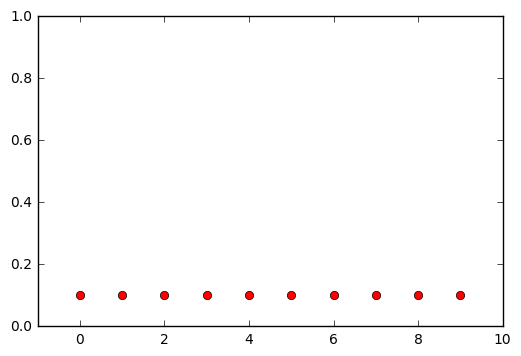

In [4]:
prior = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
print prior
plt_array(prior)

This means that the robot has the same probability in every stop

Now we get a measurement($Z$) for the robot's sensor

$Z = 3$ with accuracy = 0.6

so we can calculate the likelihood function $P(Z \mid x)$

The accuracy here can be converted to a probability scale($ps$): $$ps = (accuracy / 1-accuracy)$$


In [5]:
Z = 3
accuracy = 0.6
ps = accuracy/(1-accuracy)
print ps
likelihood = np.ones(len(stops), dtype=float)*0.1
likelihood[stops==Z] *= ps

1.5


[ 0.1   0.1   0.1   0.15  0.1   0.1   0.1   0.1   0.1   0.1 ]


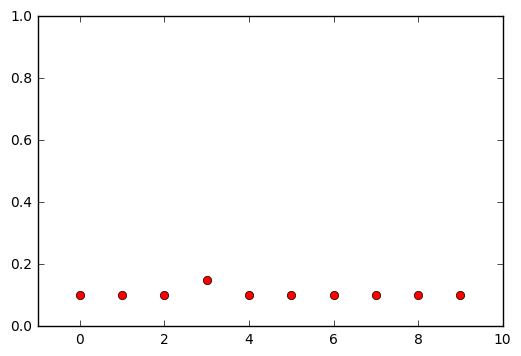

In [6]:
print likelihood
plt_array(likelihood)

As you can see here, the likelihood function is not a probability distribution. The sum of all $x$ is not 1

Now lets calulate $P(Z)$

In [7]:
normalization_factor = np.sum(likelihood*prior)
print normalization_factor

0.105


After we've got all the values on the right hand side of the bayes formula:
$$P(x \mid Z) = \frac{P(Z \mid x) P(x)}{P(Z)}$$

In [8]:
posterior = (likelihood*prior)/normalization_factor

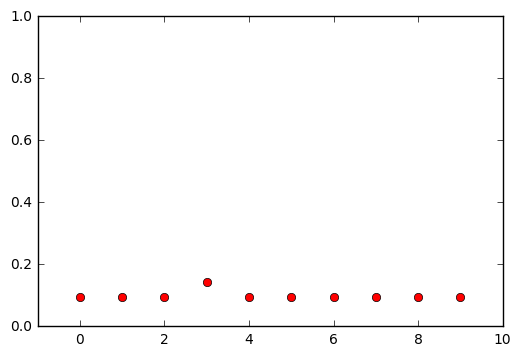

In [9]:
plt_array(posterior)

As you can see the probabilty of at x=3 is slightly bigger than other locations

For bayes filter, we do this process recursively:

Which means that we take every posterior and make it  the prior of the next iteration

For convenience, I make the previous steps into a function that I can simple call in every iteration

In [10]:
def update(prior, stops, measurement, accuracy):
    Z = measurement
    ps = accuracy/(1-accuracy)
    likelihood = np.ones(len(stops), dtype=float)
    likelihood[stops==Z] *= ps
    normalization_factor = np.sum(likelihood*prior)
    posterior = (likelihood*prior)/normalization_factor
    return posterior

Let's initialize stops and prior as we previously did 

In [11]:
stops = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
prior = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Now let's call update recursively and plot the posterior in each iteration. We assume that the sensor has a consistent measurement Z=3 accuracy=0.9

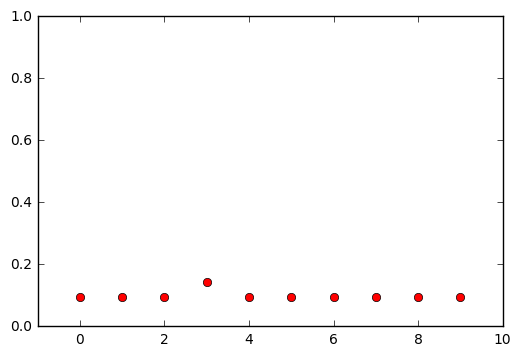

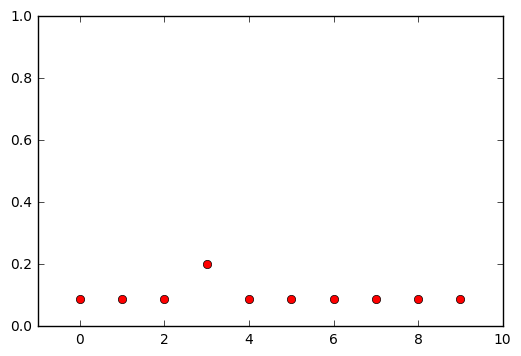

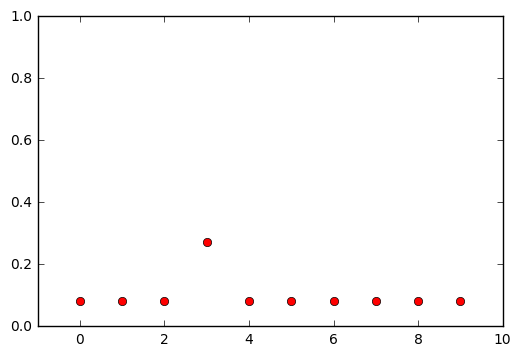

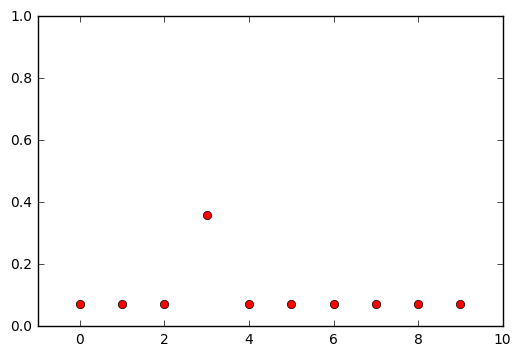

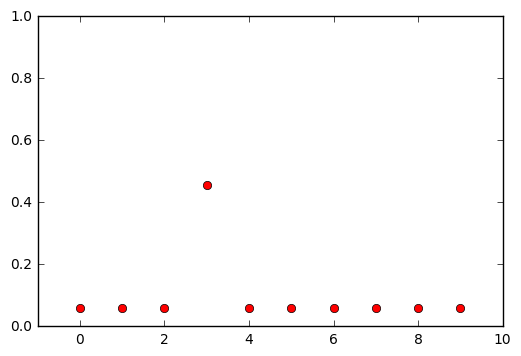

In [12]:
Z = 3
accuracy = 0.6
for i in range(5):
    posterior = update(prior, stops, Z, accuracy)
    plt_array(posterior)
    prior = posterior

As you can see here, the probabilty of $x=3$ increases gradually. It makes sense because the sensor has consistent getting measurements at $x=3$ which convinces us that the robot is really here.

Let's do the add some noise to the measurement for more realistic results

We create a random number R between 0~1

$if R<0.2$ => $Z-1, accuracy-0.3$

$if R>0.8$ => $Z+1, accuracy-0.3$

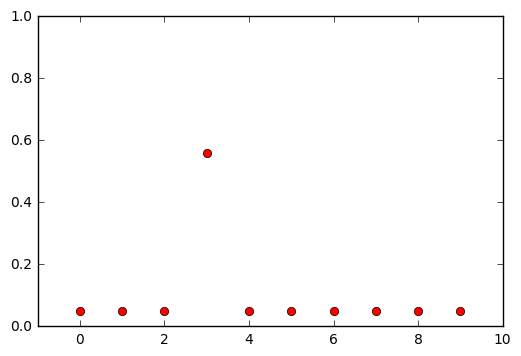

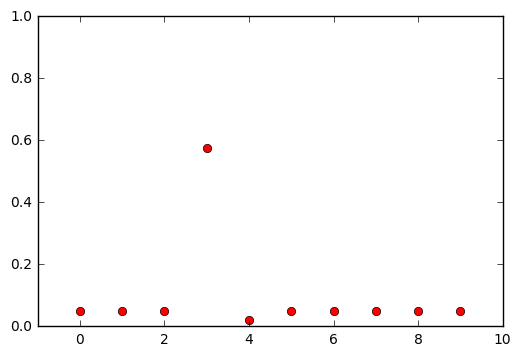

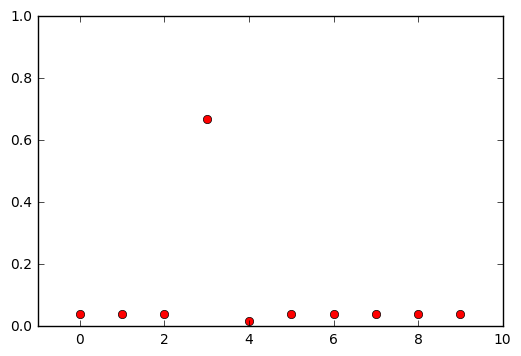

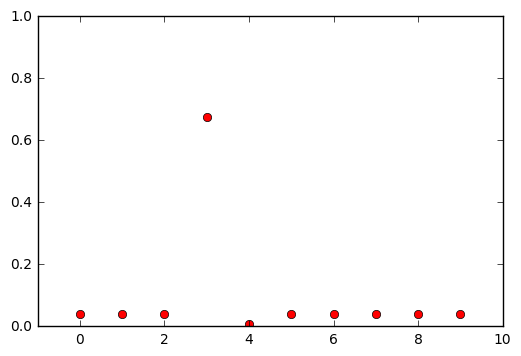

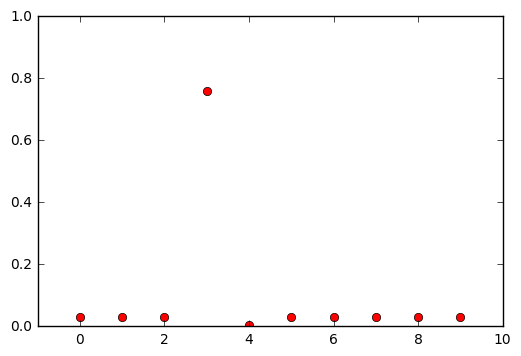

In [13]:
Z = 3
accuracy = 0.6
for i in range(5):
    R = random.random()
    if R<0.2:  
        posterior = update(prior, stops, Z-1, accuracy-0.3)
    if R>0.8:  
        posterior = update(prior, stops, Z+1, accuracy-0.3)
    else:
        posterior = update(prior, stops, Z, accuracy)
    plt_array(posterior)
    prior = posterior

This is only the update part of the Baysian Filter. The other part is the prediction part. In other words, we assume that the robot is not moving anywhere throughout every iteration.

For the prediction, the idea is very simple. If the robot moves right by N units, we shift the prior left by N units

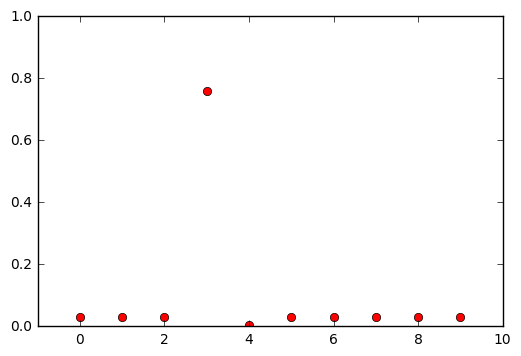

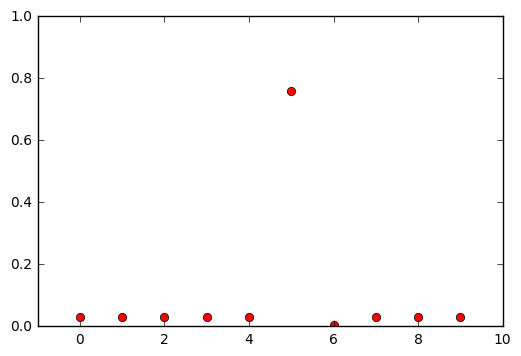

In [14]:
N=2
plt_array(prior)
predicted_prior = copy.copy(prior)
for i in range(len(prior)):
    predicted_prior[i]=prior[(i-N)%(len(prior))]
plt_array(predicted_prior)

For more realistic cases, prediction may also have uncertainty. We can write down the probabilities to each movement

move right N-1 units with probability of 0.2

move right N units with probability of 0.6

move right N+1 units with probability of 0.2

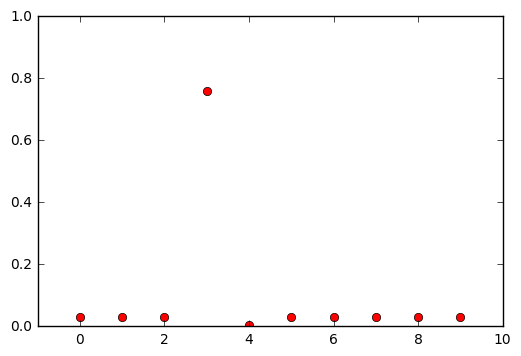

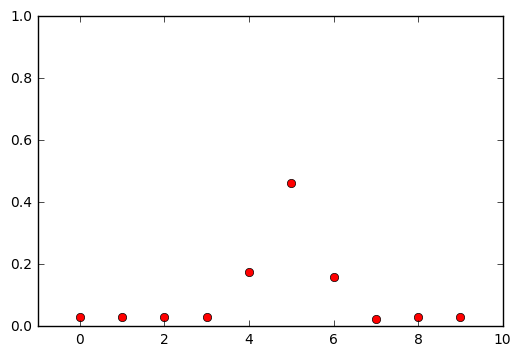

In [15]:
N=2
plt_array(prior)
predicted_prior = copy.copy(prior)
for i in range(len(prior)):
    predicted_prior[i]=prior[(i-N+1)%(len(prior))]*0.2+prior[(i-N)%(len(prior))]*0.6+prior[(i-N-1)%(len(prior))]*0.2
plt_array(predicted_prior)

What we're doing above is actually convolution. [0.2 0.6 0.2] is our kernel

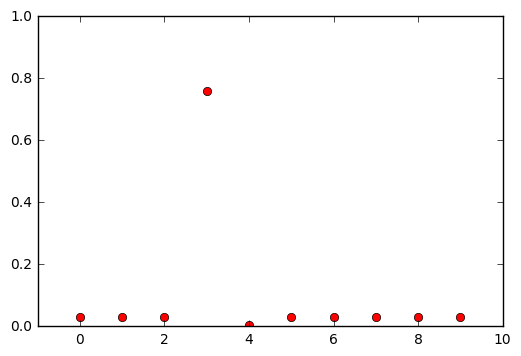

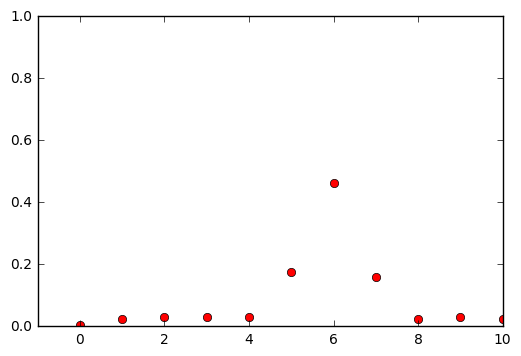

In [16]:
N=2
plt_array(prior)
kernel = np.array([0.2, 0.6, 0.2])
predicted_prior = np.convolve(np.roll(prior, N), kernel)
plt_array(predicted_prior)

## For each iteration in Bayes Filter we predict first then update.

The filter equations are:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$


We can express this whole process in pseudocode.

**Initialization**

    1. Initialize our belief in the state
    
**while(1){**


**Predict**

    1. Based on the system behavior, predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Determine whether the measurement matches each state
    4. Update state belief if it matches the measurement
**}** 


One important thing I'm addressing is that the above discrete bayes filter is easy to implement. We simply calculate each values for each $x$. However you can't do that in the continuous state space.

### Let's see the continuous case

#### For the update step:

Let's revisit the bayes formula
$$P(x \mid Z) = \frac{P(Z \mid x) P(x)}{P(Z)}$$

Let's make the continuous state space x be in $\{0,9\}$

$P(x)$ is the prior, which means the probabilty distribution of the robots position x. For initialization, we simply define it as an a uniform distibution in scope $\{0,9\}$

However, $P(Z \mid x)$ is based on the properties of the sensor. It could be any type of probability distribution.

For $P(Z)$ we simply change the summation to integration
$${\int P(Z \mid x) P(x) \mathtt{d}x}\cdot$$

Every term seems pretty simple here. But if you start calculating recursively the product of $P(Z \mid x)$ and $P(x)$ becomes more and more complicated after each iteration


#### For the predict step:

$$\bar {\mathbf x} = \mathbf x \ast f_{\mathbf x}(\bullet)\ $$

If x and $f_x$ are both a strange distribution, we can't simplify this form. Calculating convolutions also require lots of computation power

#### The savior: Gaussian Distribution 

To fix all these problems in the update and predict steps, we use the property that products of gaussians are still gaussian. And the mean and variance can be simply formulated.

$$N(\mu_1, \sigma_1^2)xN(\mu_2, \sigma_2^2)=N(\frac{\sigma_1^2\mu_2+\sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}, \frac{1}{\frac{1}{\sigma_1^2}+\frac{1}{\sigma_2^2}})$$

Another property of the gaussian distribution is that it remains gaussian after Fourier transform.
So the fourier transform of the convolution of two gaussian functions is equal to multiplication of two gaussian functions.  

By calculating the product in Frequency space and transforming back, you can find that the convolution of two gaussian is equal to the sum of two gaussians.

First gaussian distribution $N(a, A)$

Second gaussian distribution $N(b, B)$

$$F(N(a, A))=N(iA^{-1}a, A^{-1})$$
$$F(N(b, B))=N(iB^{-1}b, B^{-1})$$

$$F(N(a, A))*F(N(b, B)) = N(\frac{A^{-1}iB^{-1}b+B^{-1}iA^{-1}a}{A^{-1}+B^{-1}}, (A+B)^{-1})$$

$$=N(i(A+B)^{-1}(a+b), (A+B)^{-1})$$

Let $C = (A+B)^{-1}$

$$F^{-1}(N(iC(a+b),C)) = N(a+b, A+B)$$

So if we assume every probabilty as an gaussian distribution, the Bayesian Filter can be simplifed to a closed form representation called Kalman Filter

## Kalman Filter

#### Update step:

Let's do the previous calculation with the assumption: sensor probability is gaussian distribution with mean($\mu$) = measurement and a standard deviation($\sigma$) = $(variance)^{0.5}$

In [17]:
def measurement(measurementx, variance):
    likelihood = norm(loc = measurementx, scale = np.sqrt(variance))
    return likelihood

In [18]:
fig, ax = plt.subplots(1, 1)
likelihood = measurement(3, 0.5)

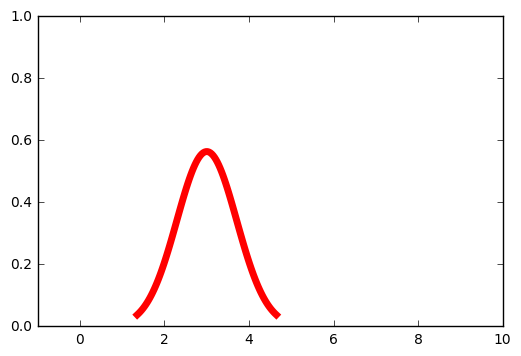

In [19]:
x = np.linspace(likelihood.ppf(0.01), likelihood.ppf(0.99), 100)
ax.plot(x, likelihood.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

For the prior, we can assume its a gaussian distribution with a large $\sigma$

In [20]:
fig, ax = plt.subplots(1, 1)
prior = norm(loc = 5, scale = 1000)

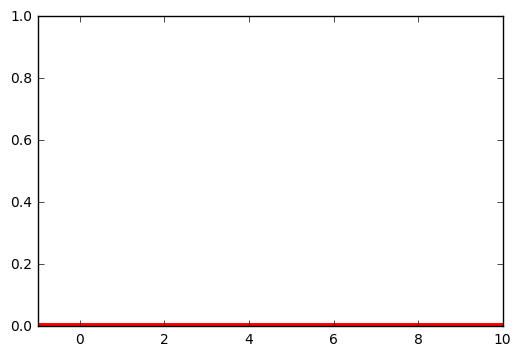

In [21]:
x = np.linspace(prior.ppf(0.01), prior.ppf(0.99), 100)
ax.plot(x, prior.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

calculate the product of $P(Z|x)$ and $P(x)$ by the formula
$$N(\mu_1, \sigma_1^2)xN(\mu_2, \sigma_2^2)=N(\frac{\sigma_1^2\mu_2+\sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}, \frac{1}{\frac{1}{\sigma_1^2}+\frac{1}{\sigma_2^2}})$$

In [22]:
def gaussian_multiply(g1, g2):
    g1_mean, g1_var = g1.stats(moments='mv')
    g2_mean, g2_var = g2.stats(moments='mv')
    mean = (g1_var * g2_mean + g2_var * g1_mean) / (g1_var + g2_var)
    variance = (g1_var * g2_var) / (g1_var + g2_var)
    #print mean, variance
    return norm(loc = mean, scale = np.sqrt(variance))

In [23]:
posterior = gaussian_multiply(likelihood, prior)

In [24]:
posterior.stats()

(array(3.0000009999995), array(0.4999997500001251))

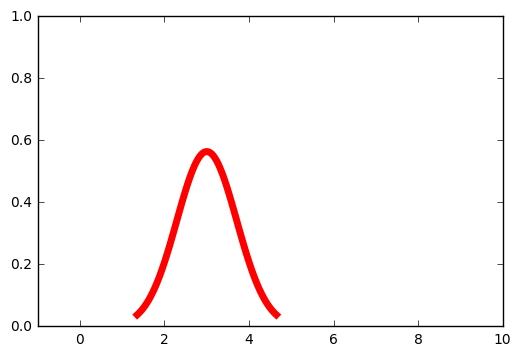

In [25]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(posterior.ppf(0.01), posterior.ppf(0.99), 100)
ax.plot(x, posterior.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

Let's repeat the process for several iterations

In [27]:
prior = norm(loc = 5, scale = 1000)

In [28]:
def update_con(prior, measurementz, covariance):
    likelihood = measurement(measurementz, covariance)
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

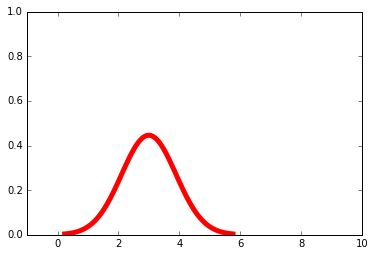

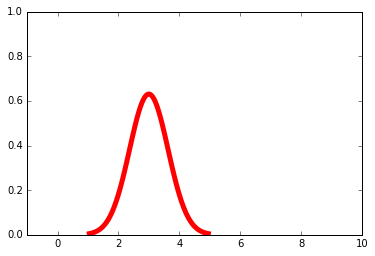

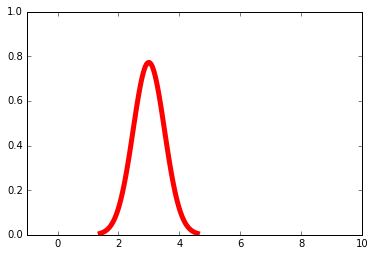

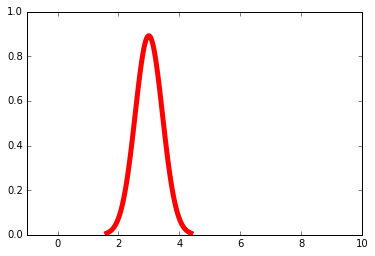

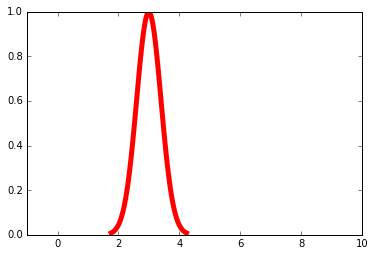

In [29]:
Z = 3
covariance = 0.8
for i in range(5):
    posterior = update_con(prior, Z, covariance)
    prior = posterior
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(posterior.ppf(0.001), posterior.ppf(0.999), 100)
    ax.plot(x, posterior.pdf(x), 'r-', lw=5, alpha=1)
    plt.axis([-1, 10, 0, 1])
    plt.show()

Let's add noise to measurement

We create a random number R between 0~1

$if R<0.2$ => $Z-1, covariance+0.3$

$if R>0.8$ => $Z+1, covariance+0.3$

In [30]:
prior = norm(loc = 5, scale = 1000)

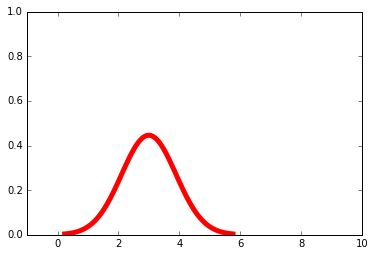

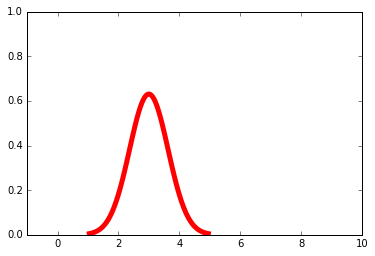

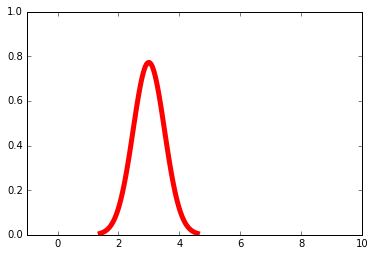

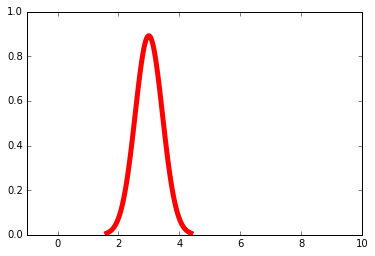

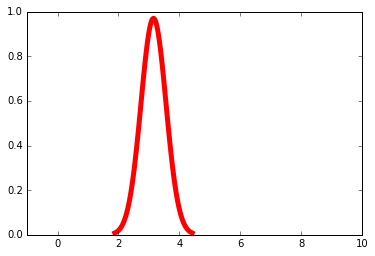

In [31]:
Z = 3
covariance = 0.8
for i in range(5):
    R = random.random()
    if R < 0.2:
        posterior = update_con(prior, Z-1, covariance+0.3)
    if R > 0.8:
        posterior = update_con(prior, Z+1, covariance+0.3)
    else:
        posterior = update_con(prior, Z, covariance)
    prior = posterior
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(posterior.ppf(0.001), posterior.ppf(0.999), 100)
    ax.plot(x, posterior.pdf(x), 'r-', lw=5, alpha=1)
    plt.axis([-1, 10, 0, 1])
    plt.show()

#### Prediction step

This is the prior

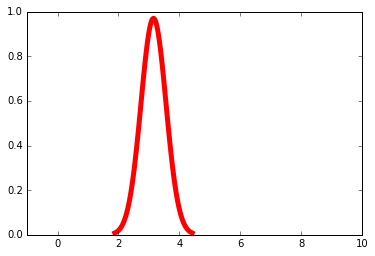

In [32]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(prior.ppf(0.001), prior.ppf(0.999), 100)
ax.plot(x, prior.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

Let's assume our movement kernel is a Gaussian distribution with mean = prior.mean()+ delta_x, $\sigma = 1$ 

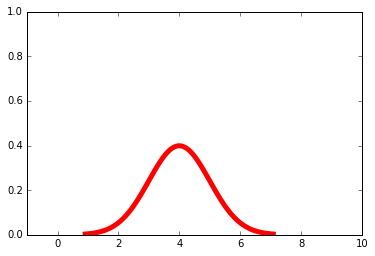

In [33]:
delta_x = 4
var = 1
kernel = norm(loc = delta_x, scale = np.sqrt(var))
fig, ax = plt.subplots(1, 1)
x = np.linspace(kernel.ppf(0.001), kernel.ppf(0.999), 100)
ax.plot(x, kernel.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

The sum of the two gaussians

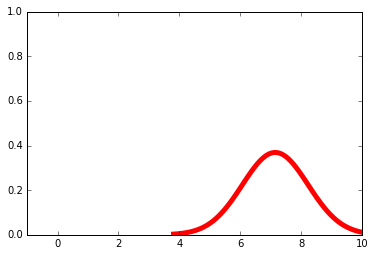

In [34]:
predicted = norm(loc = prior.mean()+kernel.mean(), scale = np.sqrt(prior.var()+kernel.var()))
fig, ax = plt.subplots(1, 1)
x = np.linspace(predicted.ppf(0.001), predicted.ppf(0.999), 100)
ax.plot(x, predicted.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

In Kalman Filter, the predict and update iteration is as same as Bayes filter

Let's make a simultation: 

a robot with a gps sensor that moves 1 unit right every timeslice. Its starting position is 0

In [42]:
def predict_con(prior, delta_x, var):
    kernel = norm(loc = delta_x, scale = np.sqrt(var))
    predicted = norm(loc = prior.mean()+kernel.mean(), scale = np.sqrt(prior.var()+kernel.var()))
    return predicted

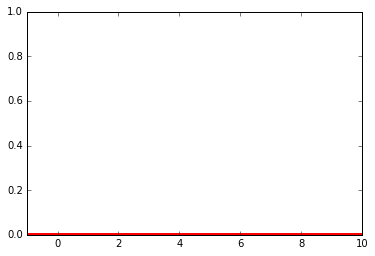

In [75]:
prior = norm(loc = 0, scale = 1000)

fig, ax = plt.subplots(1, 1)
x = np.linspace(prior.ppf(0.001), prior.ppf(0.999), 100)
ax.plot(x, prior.pdf(x), 'r-', lw=5, alpha=1)
plt.axis([-1, 10, 0, 1])
plt.show()

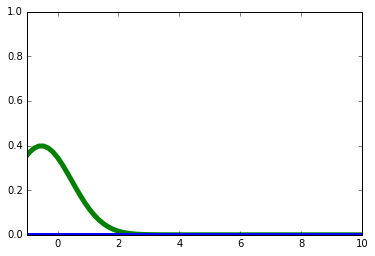

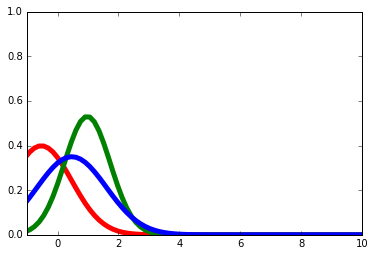

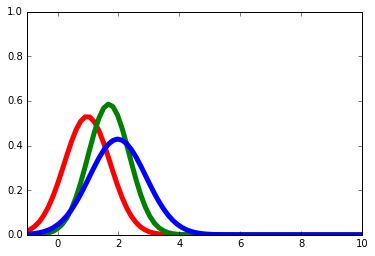

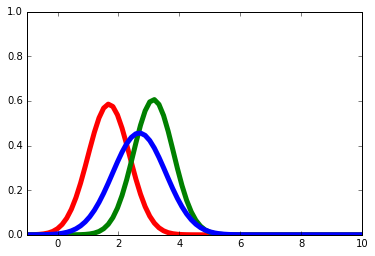

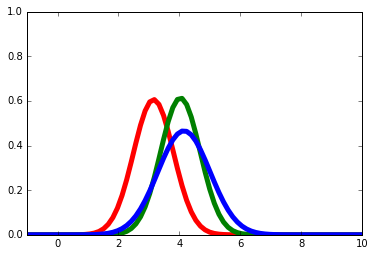

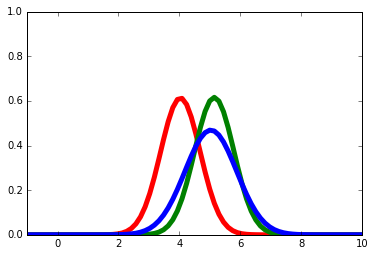

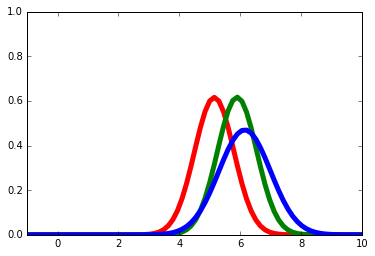

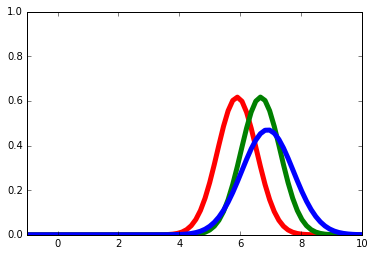

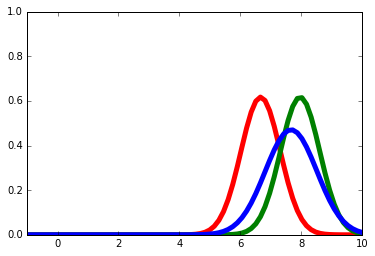

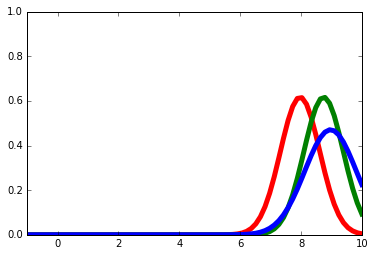

In [76]:
control_covariance = 0.3
measurement_covariance = 1

for i in range(10):
    control_sig = 1
    sim_location = i + random.random() - 0.5
    sim_measurement = sim_location + random.random() - 0.5
    predicted = predict_con(prior, control_sig, control_covariance)
    posterior = update_con(predicted, sim_measurement, measurement_covariance)
    
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(-5, 10, 100)
    ax.plot(x, prior.pdf(x), 'r-', lw=5, alpha=1)
    ax.plot(x, posterior.pdf(x), 'g-', lw=5, alpha=1)
    ax.plot(x, predicted.pdf(x), 'b-', lw=5, alpha=1)
    plt.axis([-1, 10, 0, 1])
    plt.show()
    prior = posterior